# Creating baseline performance for MPI


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-10-09 16:52:57.095476: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-10-09 16:52:57.096082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
mpi_data_path = "../../data/mpi_001"

dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_45639/479448007.py:31: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [ ]:
xco2_df = pd.DataFrame()
xco2_df["XCO2"] = xco2.XCO2
xco2_df.index = xco2.time

# data_read=xr.merge([mld.MLD,mld.MLD_socat,chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])
# data_read=xr.merge([mld.MLD,chl.Chl,sst.SST,sss.SSS])

data_read=xr.merge([chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])


tmp_data=data_read.to_dataframe().reset_index()
tmp_data["time"] = tmp_data["time"].dt.strftime("%Y-%m")
tmp_data = xco2_df.join(tmp_data.set_index('time'),how = "right")

In [ ]:
tmp_data.dropna(subset = ["XCO2"], inplace=True)
tmp_data = tmp_data.reset_index()
#tmp_data.columns = ["time",'XCO2','xlon', 'ylat','MLD','MLD_socat','Chl','Chl_socat','SST','SST_socat','SSS','SSS_socat']
tmp_data.columns = ["time",'XCO2','xlon', 'ylat','Chl','Chl_socat','SST','SST_socat','SSS','SSS_socat']


later_df = tmp_data

In [ ]:
later_df.head()

,time,XCO2,xlon,ylat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat
0,1982-02,340.848541,0.5,-89.5,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-02,340.848541,0.5,-88.5,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-02,340.848541,0.5,-87.5,NaN,NaN,NaN,NaN,NaN,NaN
3,1982-02,340.848541,0.5,-86.5,NaN,NaN,NaN,NaN,NaN,NaN
4,1982-02,340.848541,0.5,-85.5,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tmp_data.dropna(subset = ["Chl"], inplace=True)
tmp_data.isna().sum()

time         0
XCO2         0
xlon         0
ylat         0
Chl          0
Chl_socat    0
SST          0
SST_socat    0
SSS          0
SSS_socat    0
dtype: int64

In [ ]:
pco2_data = pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat = pco2.pCO2_socat.to_dataframe().reset_index()


tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

tmp_data.dropna(subset = ["pCO2"], inplace=True)

In [ ]:
tmp_data.head()

,time,XCO2,xlon,ylat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat,pCO2_socat,pCO2
4491,1982-02,340.848541,24.5,81.5,0.000545,0.0,-1.899268,-0.0,33.838451,0.0,0.0,192.137589
4492,1982-02,340.848541,24.5,82.5,0.000546,0.0,-1.898871,-0.0,33.419563,0.0,0.0,188.458038
4493,1982-02,340.848541,24.5,83.5,0.000563,0.0,-1.899603,-0.0,32.428059,0.0,0.0,185.353271
4494,1982-02,340.848541,24.5,84.5,0.000565,0.0,-1.899969,-0.0,32.275085,0.0,0.0,186.413223
4495,1982-02,340.848541,24.5,85.5,0.000552,0.0,-1.899725,-0.0,31.889830,0.0,0.0,186.520767


In [ ]:
time = tmp_data.time

In [ ]:

#features_socat = ['xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
#features = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

features_socat = ['xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']



# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [ ]:
X_socat=combined_socat.iloc[:,:-1]
X=combined.iloc[:,:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [ ]:
y.isna().sum(), y.shape

(0, (10470600,))

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

regressor=RandomForestRegressor(n_estimators=20, random_state=42, verbose=3,n_jobs=-1, 
                                max_depth=10,warm_start= True)
regressor.fit(X_train, y_train)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

forest_scores = cross_val_score(regressor, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   48.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   48.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   45.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[P

Scores: [39.84218271 39.72166349 39.7158717 ]
Mean: 39.759905966694284
Standard deviation: 0.05822647069269309


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s finished


In [ ]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.1s finished


39.70344219851587

In [ ]:
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.3s finished


362.26302028572417

In [ ]:
## Full Data
# rmse with MLD : 40.462 uatm -> 31.9733 uatm
# rmse with Dist : 41.541 uatm -> 32.84 uatm with coordinate

## Socat 
# # rmse with MLD : on full  348.32 uatm with coordinate

In [ ]:
predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','Chl','SST','SSS','XCO2'])
#predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
predicted_df["pred"] = y_pred

In [ ]:
predicted_df["res"] = error.to_numpy()
predicted_df["true"] = y.to_numpy()

In [ ]:
predicted_df.head()

,xlon,ylat,Chl,SST,SSS,XCO2,pred,res,true
0,24.5,81.5,-1.899268,33.838451,0.000545,340.848541,0.082873,192.054715,192.137589
1,24.5,82.5,-1.898871,33.419563,0.000546,340.848541,0.082873,188.375165,188.458038
2,24.5,83.5,-1.899603,32.428059,0.000563,340.848541,0.082873,185.270398,185.353271
3,24.5,84.5,-1.899969,32.275085,0.000565,340.848541,0.082873,186.330350,186.413223
4,24.5,85.5,-1.899725,31.889830,0.000552,340.848541,0.066084,186.454683,186.520767


In [ ]:
later_df.isna().sum(), later_df.shape

(time          0
 XCO2          0
 xlon          0
 ylat          0
 Chl           0
 Chl_socat     0
 SST           0
 SST_socat     0
 SSS           0
 SSS_socat     0
 pCO2_socat    0
 pCO2          0
 dtype: int64,
 (10470600, 12))

In [ ]:
later_df = later_df.reset_index(drop=True)

In [ ]:
later_df.head()

,time,XCO2,xlon,ylat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat,pCO2_socat,pCO2
0,1982-02,340.848541,24.5,81.5,0.000545,0.0,-1.899268,-0.0,33.838451,0.0,0.0,192.137589
1,1982-02,340.848541,24.5,82.5,0.000546,0.0,-1.898871,-0.0,33.419563,0.0,0.0,188.458038
2,1982-02,340.848541,24.5,83.5,0.000563,0.0,-1.899603,-0.0,32.428059,0.0,0.0,185.353271
3,1982-02,340.848541,24.5,84.5,0.000565,0.0,-1.899969,-0.0,32.275085,0.0,0.0,186.413223
4,1982-02,340.848541,24.5,85.5,0.000552,0.0,-1.899725,-0.0,31.889830,0.0,0.0,186.520767


In [24]:
predicted_df.isna().sum(), predicted_df.shape

(xlon    0
 ylat    0
 Chl     0
 SST     0
 SSS     0
 XCO2    0
 pred    0
 res     0
 true    0
 dtype: int64,
 (10470600, 9))

In [25]:
predicted_df.head()

,xlon,ylat,Chl,SST,SSS,XCO2,pred,res,true
0,24.5,81.5,-1.899268,33.838451,0.000545,340.848541,0.082873,192.054715,192.137589
1,24.5,82.5,-1.898871,33.419563,0.000546,340.848541,0.082873,188.375165,188.458038
2,24.5,83.5,-1.899603,32.428059,0.000563,340.848541,0.082873,185.270398,185.353271
3,24.5,84.5,-1.899969,32.275085,0.000565,340.848541,0.082873,186.330350,186.413223
4,24.5,85.5,-1.899725,31.889830,0.000552,340.848541,0.066084,186.454683,186.520767


building tree 2 of 20
building tree 7 of 20
building tree 9 of 20
building tree 13 of 20
building tree 17 of 20
building tree 1 of 20
building tree 6 of 20
building tree 10 of 20
building tree 15 of 20
building tree 18 of 20
building tree 4 of 20
building tree 5 of 20
building tree 9 of 20
building tree 14 of 20
building tree 17 of 20
building tree 4 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building tree 19 of 20
building tree 3 of 20
building tree 8 of 20
building tree 12 of 20
building tree 14 of 20
building tree 19 of 20
building tree 2 of 20
building tree 6 of 20
building tree 11 of 20
building tree 13 of 20
building tree 18 of 20
building tree 1 of 20
building tree 5 of 20
building tree 11 of 20
building tree 15 of 20
building tree 18 of 20
building tree 2 of 20
building tree 5 of 20
building tree 9 of 20
building tree 16 of 20
building tree 17 of 20
building tree 1 of 20
building tree 8 of 20
building tree 12 of 20
building tree 16 of 20
building 

In [26]:
#new_df = pd.merge(later_df, predicted_df,  how='inner', left_on=['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'], right_on = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
new_df = pd.merge(later_df, predicted_df,  how='inner', 
                  left_on=['xlon', 'ylat','SST','SSS','Chl','XCO2'], 
                  right_on = ['xlon', 'ylat','SST','SSS','Chl','XCO2'])





,time,XCO2,xlon,ylat,Chl,Chl_socat,SST,SST_socat,SSS,SSS_socat,pCO2_socat,pCO2,pred,res,true


In [28]:
new_df.isna().sum()

time          0.0
XCO2          0.0
xlon          0.0
ylat          0.0
Chl           0.0
Chl_socat     0.0
SST           0.0
SST_socat     0.0
SSS           0.0
SSS_socat     0.0
pCO2_socat    0.0
pCO2          0.0
pred          0.0
res           0.0
true          0.0
dtype: float64

In [ ]:
col_names = ["time","lon","lat","pred"]
pred_df = new_df[["time","xlon","ylat","pred"]]
pred_df.columns = col_names
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.set_index(["time","lat","lon"])


col_names = ["time","lon","lat","res"]

res_df = new_df[["time","xlon","ylat","res"]]
res_df.columns = col_names
res_df['time'] = pd.to_datetime(res_df['time'])
res_df = res_df.set_index(["time","lat","lon"])


pred_xarray = pred_df.to_xarray()
res_xarray = res_df.to_xarray()

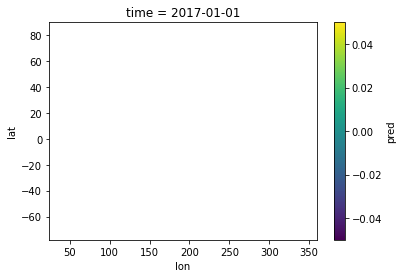

In [30]:
pred_xarray.pred[419].plot()

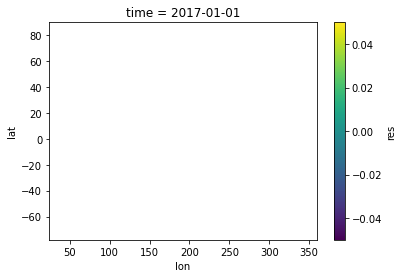

In [31]:
res_xarray.res[419].plot()

/tmp/ipykernel_33320/3732057223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['time'] = pd.to_datetime(true_df['time'])


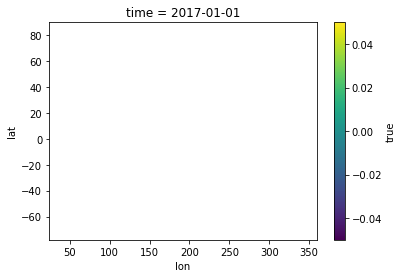

In [32]:
col_names = ["time","lon","lat","true"]
true_df = new_df[["time","xlon","ylat","true"]]
true_df.columns = col_names
true_df['time'] = pd.to_datetime(true_df['time'])
true_df = true_df.set_index(["time","lat","lon"])


true_xarray = true_df.to_xarray()

true_xarray.true[419].plot()

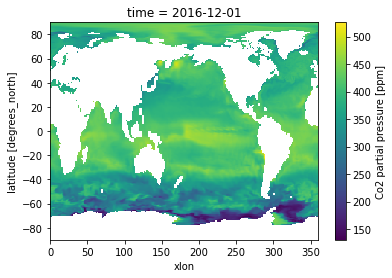

In [33]:
pco2.pCO2[419].plot()